In [9]:
import torch

from rl4co.envs import TSPEnv, PDPEnv, RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

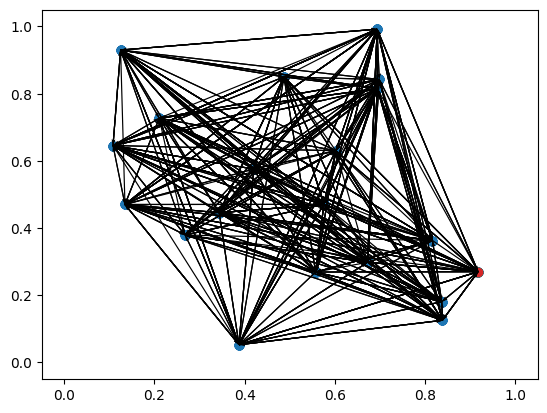

In [64]:
from typing import Optional
import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.pylogger import get_pylogger
log = get_pylogger(__name__)

def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    """Reset the environment to the initial state"""
    # If no TensorDict is provided, generate a new one
    init_locs = td["locs"] if td is not None else None
    # If no batch_size is provided, use the batch_size of the initial locations
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    # If no device is provided, use the device of the initial locations
    device = init_locs.device if init_locs is not None else self.device 
    self.to(device)
    # If no initial locations are provided, generate new ones
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size).to(device)["locs"]
    # If batch_size is an integer, convert it to a list
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Get the number of locations
    num_loc = init_locs.shape[-2]

    # Initialize a start and end node
    first_node = torch.zeros((batch_size), dtype=torch.int64, device=device)
    end_node = torch.full((batch_size), num_loc - 1, dtype=torch.int64, device=device)

    # represent the availability of each node in the environment for each batch
    available = torch.ones((*batch_size, num_loc), dtype=torch.bool, device=device)
    
    # Initialize the index of the current node 
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "locs": init_locs,
            "first_node": first_node,
            "current_node": first_node,
            "end_node": end_node,
            "i": i,
            "action_mask": available,
            "reward": torch.zeros((*batch_size, 1), dtype=torch.float32),
        },
        batch_size=batch_size,
    )

def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]

    first_node = current_node if td["i"].all() == 0 else td["first_node"]

    # Mark the current node as visited
    available = td["action_mask"].scatter(
        -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    )
    
    # available = td["action_mask"].scatter(
    #    -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    # )

    # Terminate the episode when the agent reaches the end node
    done = current_node == td["end_node"]

    # The reward is calculated outside via get_reward for efficiency, so we set it to 0 here
    reward = torch.zeros_like(done)

    td.update(
        {
            "first_node": first_node,
            "current_node": current_node,
            "i": td["i"] + 1,
            # "action_mask": available,
            "reward": reward,
            "done": done,
        },
    )
    return td

def get_action_mask(self, td: TensorDict) -> TensorDict:
    # Here: your logic
    return td["action_mask"]

# def check_solution_validity(self, td: TensorDict, actions: torch.Tensor):
#     """Check that solution is valid: nodes are visited exactly once"""
#     assert (
#         torch.arange(actions.size(1), out=actions.data.new())
#         .view(1, -1)
#         .expand_as(actions)
#         == actions.data.sort(1)[0]
#     ).all(), "Invalid tour"

def get_reward(self, td, actions) -> TensorDict:
    # if self.check_solution:
    #     self.check_solution_validity(td, actions)
    # Reward the agent based on the length of the path from the start node to the end
    locs_ordered = gather_by_index(td["locs"], actions)
    return -get_tour_length(locs_ordered)

def _make_spec(self, td_params):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            low=self.min_loc,
            high=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        start_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        end_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        low=0,
        high=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    locs = (
        torch.rand((*batch_size, self.num_loc, 2), generator=self.rng)
        * (self.max_loc - self.min_loc)
        + self.min_loc
    )
    return TensorDict({"locs": locs}, batch_size=batch_size)

def render(self, td, actions=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots()

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]

    locs = td["locs"]

    # gather locs in order of action if available
    if actions is None:
        print("No action in TensorDict, rendering unsorted locs")
    else:
        actions = actions.detach().cpu()
        locs = gather_by_index(locs, actions, dim=0)

    # Cat the first node to the end to complete the tour
    locs = torch.cat((locs, locs[0:1]))
    x, y = locs[:, 0], locs[:, 1]

    # Plot the visited nodes
    ax.scatter(x, y, color="tab:blue")

    # Highlight the start node in green
    ax.scatter(x[0], y[0], color="tab:green")

    # Highlight the end node in red
    ax.scatter(x[-1], y[-1], color="tab:red")

    # Add arrows between visited nodes as a quiver plot
    dx, dy = np.diff(x), np.diff(y)
    ax.quiver(
        x[:-1], y[:-1], dx, dy, scale_units="xy", angles="xy", scale=1, color="k"
    )

    # Setup limits and show
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

class SPPEnv(RL4COEnvBase):
    """Traveling Salesman Problem (TSP) environment"""

    name = "tsp"

    def __init__(
        self,
        num_loc: int = 20,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)

    _reset = _reset
    _step = _step
    get_reward = get_reward
    # check_solution_validity = check_solution_validity
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
        steps += 1
        if steps > max_steps:
            log.info("Max steps reached")
            break
    return (
        env.get_reward(td, torch.stack(actions, dim=1)),
        td,
        torch.stack(actions, dim=1),
    )

# from rl4co.utils.decoding import rollout, random_policy

batch_size = 2

env = SPPEnv(num_loc=5)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
env.render(td, actions)

In [65]:
env = SPPEnv(num_loc=50)

policy = AttentionModelPolicy(env.name, 
                              embedding_dim=128, 
                              num_encoder_layers=3, 
                              num_heads=8,)

model = AttentionModel(env, baseline="rollout",
                       train_data_size=100_000,
                       val_data_size=10_000,
                       optimizer_kwargs= {"lr": 1e-4},)

/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 11.73 GiB of which 39.38 MiB is free. Including non-PyTorch memory, this process has 11.02 GiB memory in use. Of the allocated memory 10.87 GiB is allocated by PyTorch, and 11.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [27]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SPPEnv               | 0     
1 | policy   | AttentionModelPolicy | 710 K 
2 | baseline | WarmupBaseline       | 710 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)


/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 196/196 [00:23<00:00,  8.27it/s, v_num=2, train/reward=-6.65, train/loss=-4.06, val/reward=-6.47] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:25<00:00,  7.65it/s, v_num=2, train/reward=-6.65, train/loss=-4.06, val/reward=-6.47]


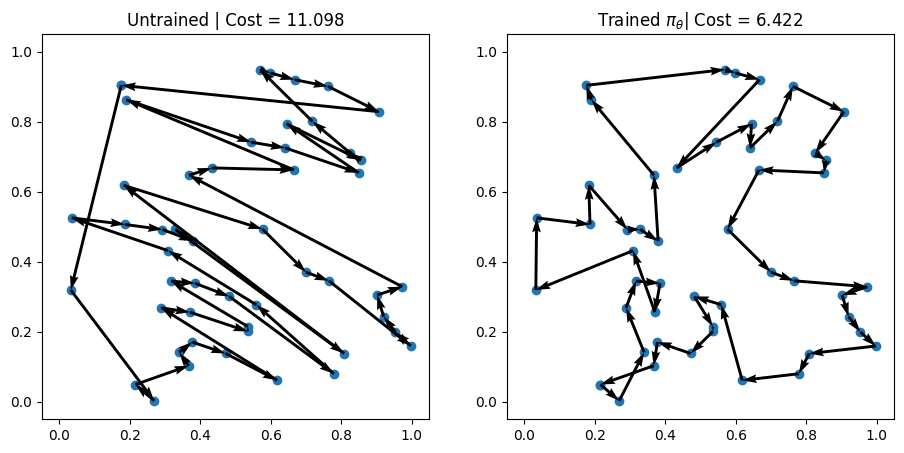

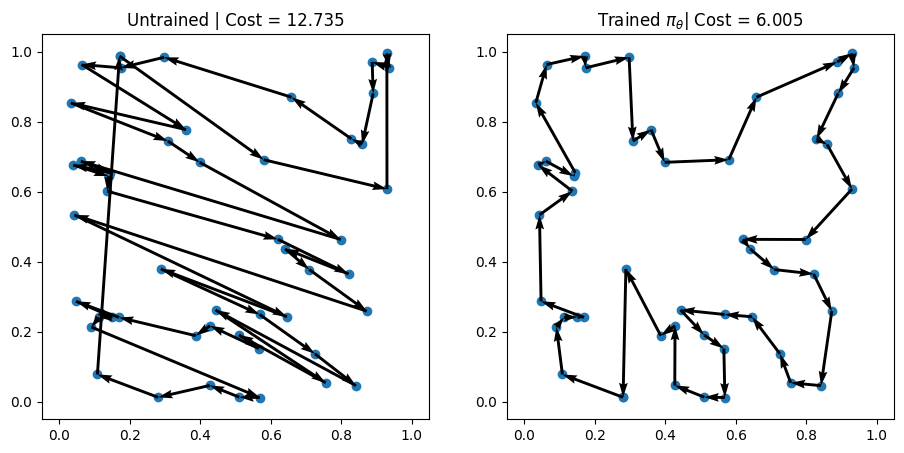

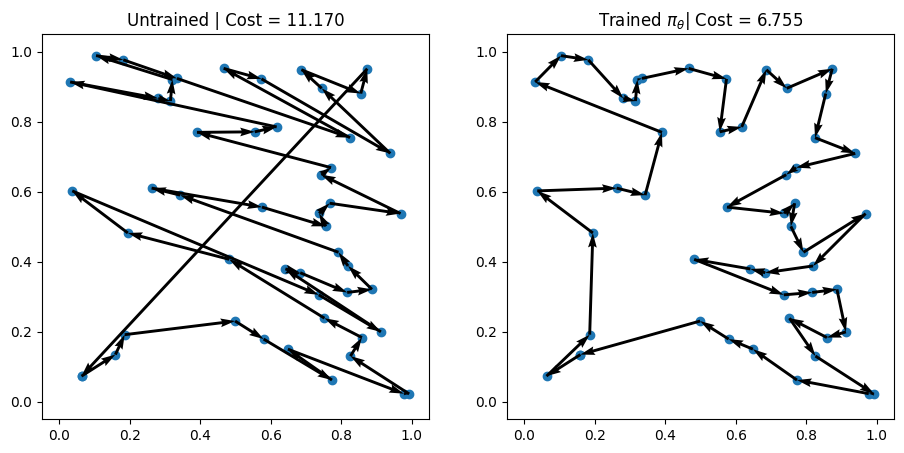

In [28]:
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")